In [1]:
import numpy as np
from PDE_FIND import *
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.sparse import csc_matrix
from scipy.sparse import linalg as spla
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import inv
from scipy.sparse import diags
from scipy.sparse import csr_matrix, triu
from scipy import linalg
from scipy import array, linalg, dot

# Data

In [4]:
data = sio.loadmat('C:/Users/Margarita/Desktop/PDE-FIND-master/Datasets/Lorenz_system.mat')

In [5]:
t = data['t'].T[0]
x = data['x'].T[0]
y = data['y'].T[0]
z = data['z'].T[0]

In [6]:
dt = t[2]-t[1]
size = t.shape[0]

In [8]:
size

100001

In [9]:
x_t = FiniteDiff(x, dt, 1)
y_t = FiniteDiff(y, dt, 1)
z_t = FiniteDiff(z, dt, 1)

In [10]:
x_t[0]

(149.99727+0j)

# SINdy identification

In [14]:
def SINdy(Theta, x, tol):
    n = x.shape[1]
##compute Sparse regression: sequential least squares 
    w = np.linalg.lstsq(Theta,x,rcond = None)[0]; ##initial guess: Least-squares
    #print(w)
## lambda is our sparsification knob. 
    for k in range(10): 
        smallinds = np.where(abs(w) < tol)[0]; ##find small coefficients 
        w[smallinds] = 0; ## and threshold 
        for ind in range(n): ## n is state dimension 
            biginds = [i for i in range(Theta.shape[1]) if i not in smallinds] 
        ## Regress dynamics onto remaining terms to find sparse Xi 
            w[biginds,ind] = np.linalg.lstsq(Theta[:, biginds],x[:, ind],rcond = None)[0]
        #print(f"{k} iteration:", w)
    return w


# Tikhonov differentiation

Tikhonov differentiation:

$(A^TA+\lambda D^TD)x = A^Tf$

In [12]:
n = x.shape[0]
xn = np.zeros(n)
yn = np.zeros(n)
zn = np.zeros(n)

In [13]:
np.random.seed(0)
noise = 1 
for i in range(n):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

## Manually Tikhonov

In [126]:
def Tikhonov_manually(x0, f, dx, iters, lam):
    n = len(f)
    f = np.array(f - f[0])

    #### FOR LARGE MATRIX #####
    ### Multiplication by the matrix A^TA ###
    y = np.zeros(n)
    b = np.zeros(n)
    y[1] = dx*x0[0]*0.5 + dx*x0[1]*0.5
    y[2] = dx*x0[0]*0.5 + dx*x0[2]*0.5 + dx*x0[1]    
    
    # Multiplication by the matrix A: Ax0 = y
    for i in range(3, n):
        y[i] = dx*x0[0]*0.5 + dx*sum(x0[1:i]) + dx*x0[i]*0.5
        
    # Multiplication by the matrix A^T: A^T*y + lam*D^TD*x0
    D = np.zeros(2)
    r = np.zeros(n)
    b[0] = dx*sum(f[1:])*0.5
    r[0] = b[0] - (dx*sum(y[1:])*0.5 + lam*(x0[0] - x0[1])/dx**2)
    
    print('The Initial residual')
    D[0] = -lam/dx**2
    D[1] = 2*lam/dx**2
    for i in range(1, n-1):
        b[i] = dx*f[i]*0.5 + dx*sum(f[i+1:])
        r[i] = b[i] - (dx*y[i]*0.5 + dx*sum(y[i+1:])+\
                       D[1]*x0[i] + D[0]*x0[i-1] + D[0]*x0[i+1])
    b[n-1] = dx*f[n-1]*0.5
    r[n-1] = b[n-1] - (dx*y[n-1]*0.5 + lam*(x0[n-1] - x0[n-2])/dx**2)
    print(np.linalg.norm(r))
    p = r.copy()
    A_p = np.zeros(n)
    print('Start CG!')
    for k in range(iters):
        y[1] = dx*p[0]*0.5 + dx*p[1]*0.5
        y[2] = dx*p[0]*0.5 + dx*p[2]*0.5 + dx*p[1]    
    
        # Multiplication by the matrix A: Ap = y
        for i in range(3, n):
            y[i] = dx*p[0]*0.5 + dx*sum(p[1:i]) + dx*p[i]*0.5
        
        # Multiplication by the matrix A^T: A^T*p + lam*D^TD*p
        A_p[0] = dx*sum(y[1:])*0.5 + lam*(p[0] - p[1])/dx**2
        for i in range(1, n-1):
            A_p[i] = dx*y[i]*0.5 + dx*sum(y[i+1:])+\
                    (D[1]*p[i] + D[0]*p[i-1] + D[0]*p[i+1])
        
        A_p[n-1] = dx*y[n-1]*0.5 + lam*(p[n-1] - p[n-2])/dx**2
        
        alpha = r.dot(r) / p.dot(A_p)
        x0 = x0 + alpha*p
        r_new = r - alpha*A_p
        beta = r_new.dot(r_new)/r.dot(r)
        p = r_new + beta*p
        #z = z_new
        r = r_new
    print(np.linalg.norm(r))
    return x0

In [286]:
def debug_initial(x0, f, dx, lam):
    n = len(f)
    f = np.array(f - f[0])
    #### SIZE <= 1000 ####
    # Get a trapezoidal approximation to an integral
    A = scipy.sparse.lil_matrix((n,n))
    for i in range(1, n):
        A[i,0] = dx/2
        for j in range(1,i): A[i,j] = dx
        A[i,i] = dx/2
    print(A.toarray())
    e = np.ones(n-1)/dx
    D = diags([e, -e], [1, 0], shape=(n-1, n))
    #print('lam*D^TD')
    b = A.T.dot(f)
    L = lam*D.T.dot(D)
    reg_A = csc_matrix(A.T.dot(A) + L)
    z = b - reg_A.dot(x0)
    
    #### FOR LARGE MATRIX #####
    ### Multiplication by the matrix A^TA ###
    y = np.zeros(n)
    A_Tf = np.zeros(n)
    y[1] = dx*x0[0]*0.5 + dx*x0[1]*0.5
    y[2] = dx*x0[0]*0.5 + dx*x0[2]*0.5 + dx*x0[1]    
    
    # Multiplication by the matrix A: Ax0 = y
    for i in range(3, n):
        y[i] = dx*x0[0]*0.5 + dx*sum(x0[1:i]) + dx*x0[i]*0.5 
    #print(np.linalg.norm(y-A.dot(x0)))
        
    # Multiplication by the matrix A^T: A^T*y + lam*D^TD*x0
    D = np.zeros(2)
    r = np.zeros(n)
    print('The Initial residual')
    A_Tf[0] = dx*sum(f[1:])*0.5
    r[0] = A_Tf[0] - (dx*sum(y[1:])*0.5 + lam*(x0[0] - x0[1])/dx**2)
    print(r[0], z[0])
    D[0] = -lam/dx**2
    D[1] = 2*lam/dx**2
    for i in range(1, n-1):
        A_Tf[i] = dx*f[i]*0.5 + dx*sum(f[i+1:])
        r[i] = A_Tf[i] - (dx*y[i]*0.5 + dx*sum(y[i+1:])+\
                          D[1]*x0[i] + D[0]*x0[i-1] + D[0]*x0[i+1])
        print(r[i], z[i])
    A_Tf[n-1] = dx*f[n-1]*0.5
    r[n-1] = A_Tf[n-1] - (dx*y[n-1]*0.5 + lam*(x0[n-1] - x0[n-2])/dx**2)
    print(r[n-1], z[n-1])
    diff = z - r
    print(np.linalg.norm(diff))
    print(np.linalg.norm(r))
    return 

## Imbedded Tikhonov

In [134]:
def simple_Tikhonov(x0, f, dx, iters, lam):
    n = len(f)
    f = np.array(f - f[0])

    # Get a trapezoidal approximation to an integral
    A = scipy.sparse.lil_matrix((n,n))
    for i in range(1, n):
        A[i,0] = dx/2
        for j in range(1,i): A[i,j] = dx
        A[i,i] = dx/2
    e = np.ones(n-1)/dx
    D = diags([e, -e], [1, 0], shape=(n-1, n))
    b = A.T.dot(f)
    L = lam*D.T.dot(D)
    reg_A = csc_matrix(A.T.dot(A) + L)
    print(np.linalg.cond(reg_A.toarray()))
    inv_A = inv(reg_A)
    sol = scipy.sparse.linalg.cg(reg_A, b, x0, 1e-05, maxiter=iters, M=inv_A, atol=10**-6)
    
    return sol

## Size = 1000

In [12]:
x0 = np.random.uniform(-100, 100, 1000)

In [287]:
debug_initial(x0, xn[:1000], dt, 10**-6)

[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.0005 0.0005 0.     ... 0.     0.     0.    ]
 [0.0005 0.001  0.0005 ... 0.     0.     0.    ]
 ...
 [0.0005 0.001  0.001  ... 0.0005 0.     0.    ]
 [0.0005 0.001  0.001  ... 0.001  0.0005 0.    ]
 [0.0005 0.001  0.001  ... 0.001  0.001  0.0005]]
The Initial residual
8.250748589681713 8.250748589681729
156.7898116774301 156.78981167742975
-254.0099988760786 -254.0099988760787
64.68548563782394 64.68548563782387
90.50040671136031 90.50040671136038
113.1431916721027 113.14319167210279
-116.53541482113017 -116.53541482113025
-116.20193350514874 -116.20193350514866
245.61718080851932 245.61718080851895
-188.40986978163522 -188.4098697816356
194.39026184558747 194.3902618455871
2.0219302832896666 2.021930283289647
-195.08153134856434 -195.08153134856474
210.66031437459398 210.66031437459364
-48.16626331698082 -48.166263316980846
-155.9330780867049 -155.93307808670534
345.0154491886993 345.0154491886993
-271.96042742276245 -271.96042742276

-125.39721427825438 -125.39721427825484
202.08306849684132 202.08306849684087
-118.47478679920196 -118.47478679920192
198.16789801815034 198.16789801814988
-75.1037419311161 -75.10374193111605
-42.19004843360145 -42.19004843360151
-124.81696897364459 -124.81696897364509
176.53524414154268 176.53524414154214
-65.07065717700763 -65.0706571770076
-5.817508107373048 -5.817508107373074
146.340928179077 146.34092817907649
-129.03400085124923 -129.03400085124971
142.47572727715357 142.47572727715306
-110.15435989749592 -110.15435989749591
90.4682711692292 90.46827116922921
-170.69940756079902 -170.69940756079959
172.95030760165122 172.95030760165074
1.881849516606863 1.881849516606871
-33.78942565332047 -33.789425653320535
-35.55381056997578 -35.55381056997582
-54.934988686686246 -54.934988686686296
114.94127616678504 114.94127616678507
-2.353028585581029 -2.353028585581063
-0.7205246910826046 -0.7205246910826117
-72.08184334266802 -72.08184334266801
87.79951947789232 87.79951947789233
76.512

In [22]:
x_tik = simple_Tikhonov(x0, xn[105:1105], dt, 1, 10**-6)

4000.490160422239


In [23]:
x_tik[1]

0

In [294]:
x_tik_m = Tikhonov_manually(x0, xn[:1000], dt, 100, 10**-6)

The Initial residual
4446.029555048541
Start CG!
0.014767026298614514


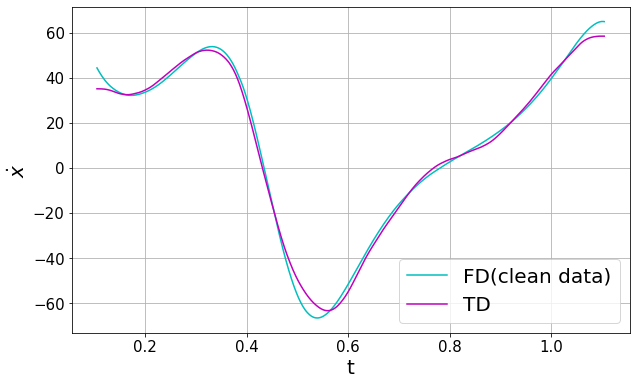

In [25]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[105:1105], x_t[105:1105].real, 'c-', label='FD(clean data)')
plt.plot(t[105:1105], x_tik[0], 'm-', label='TD')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.savefig('FD_2.pdf')

If the preconditioner is $(A^TA+\lambda D^TD)^{-1}$, then CG converges quickly (1 iteration for imbedded cg). For Incomplete Cholesky factorization everything is different, namely convergence is very slowly and oscillations are observed at the end... Assumption: it needs to another preconditioner. Without a preconditioner it works better! 

In [112]:
y_tik = simple_Tikhonov(x0, yn[:1000], dt, 1, 10**-6)

Inverse matrix


In [113]:
y_tik[1]

0

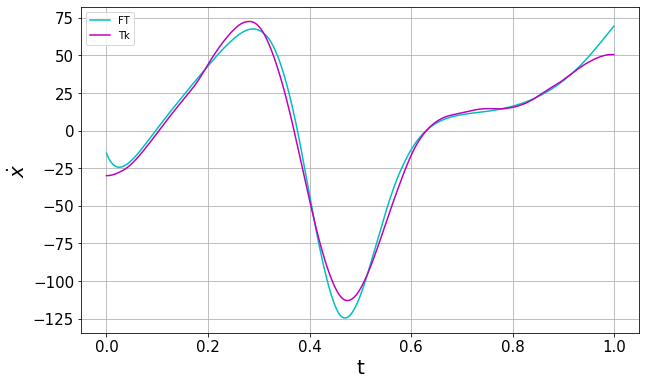

In [114]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:1000], y_t[:1000].real, 'c-', label='FD')
plt.plot(t[:1000], y_tik[0][:1000], 'm-', label='Tk')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot y$', fontsize=20)
plt.legend(loc='best')

In [126]:
subsample = 1000
xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
Theta, description = build_Theta(Xn_sub[:subsample,:], Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

In [131]:
w_xn = SINdy(Theta, x_tik[0].reshape(subsample,1), 0.5)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (24.721247 +0.000000i)
    + (-1.314277 +0.000000i)z
    + (7.345993 +0.000000i)y
    + (-6.083465 +0.000000i)x
   


In [127]:
w_yn = SINdy(Theta, y_tik[0].reshape(subsample,1), 0.25)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (18.011152 +0.000000i)
    + (-0.922827 +0.000000i)z
    + (21.610552 +0.000000i)x
    + (-0.789121 +0.000000i)xz
   


## Size = 10000

### Manually

In [296]:
x0 = np.random.uniform(-100, 100, 10000)
x_tik_m = Tikhonov_manually(x0, xn[:10000], dt, 100, 10**-6)

The Initial residual
15077.311523654864
Start CG!
2.2696638885896663


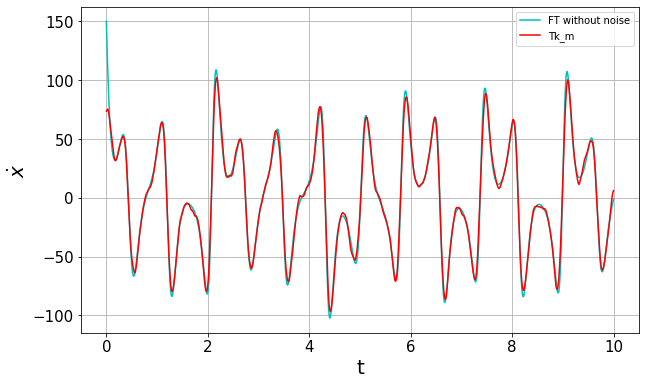

In [297]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, 'c-', label='FD without noise')
plt.plot(t[:10000], x_tik_m, 'r-', label='Tk_m')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best')

In [298]:
subsample = 10000
xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
Theta, description = build_Theta(Xn_sub[:subsample,:], Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

In [303]:
w_x = SINdy(Theta, x_tik_m.reshape(subsample, 1), 0.5)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (8.824395 +0.000000i)y
    + (-8.660147 +0.000000i)x
   


In [15]:
xs = data_smoothing(xn[:10000], xn[:10000], dt, 1, 10**-4)[0]
ys = data_smoothing(yn[:10000], yn[:10000], dt, 1, 10**-4)[0]
zs = data_smoothing(zn[:10000], zn[:10000], dt, 1, 10**-4)[0]

In [16]:
xs.shape

(10000,)

In [17]:
subsample = 10000
xs = xs.reshape(subsample, 1)
ys = ys.reshape(subsample, 1)
zs = zs.reshape(subsample, 1)
Xs_sub = np.hstack([xs,ys,zs])
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Theta_s, description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5, data_description = ['x','y','z'])

In [344]:
w_x = SINdy(Theta_s, x_tik_m.reshape(subsample, 1), 0.5)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (9.726462 +0.000000i)y
    + (-9.690634 +0.000000i)x
   


### Imbedded 

Derivatives are built from noise data and smooth data is used

In [345]:
x0 = np.random.uniform(-100, 100, 10000)
x_tik = simple_Tikhonov(x0, xn[:10000], dt, 200, 10**-6)

In [346]:
x_tik[1]

0

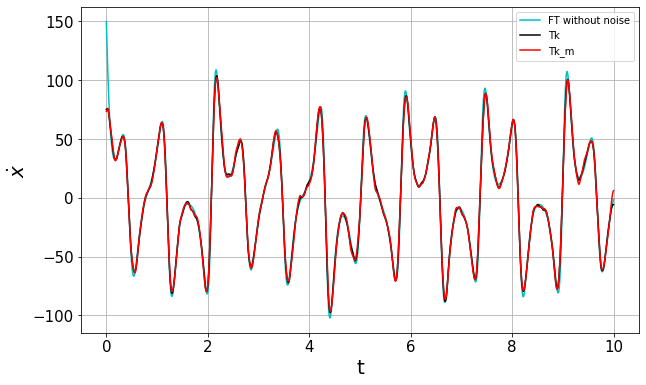

In [347]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, 'c-', label='FD without noise')
plt.plot(t[:10000], x_tik[0], color='black', label='Tk')
plt.plot(t[:10000], x_tik_m, 'r-', label='Tk_m')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best')

 maxiter = 100

In [323]:
w_x = SINdy(Theta_s, x_tik[0].reshape(subsample, 1), 0.25)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (9.725092 +0.000000i)y
    + (-9.690578 +0.000000i)x
   


maxiter = 200

In [348]:
w_x = SINdy(Theta_s, x_tik[0].reshape(subsample, 1), 0.25)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (9.737873 +0.000000i)y
    + (-9.706524 +0.000000i)x
   


Use smooth data: the result doesn't improve...

In [18]:
x0 = np.random.uniform(-100, 100, 10000)
x_tik = simple_Tikhonov(x0, xs, dt, 200, 10**-6)

In [27]:
w_x = SINdy(Theta_s, x_tik[0].reshape(subsample, 1), 0.5)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (9.620449 +0.000000i)y
    + (-9.588698 +0.000000i)x
   


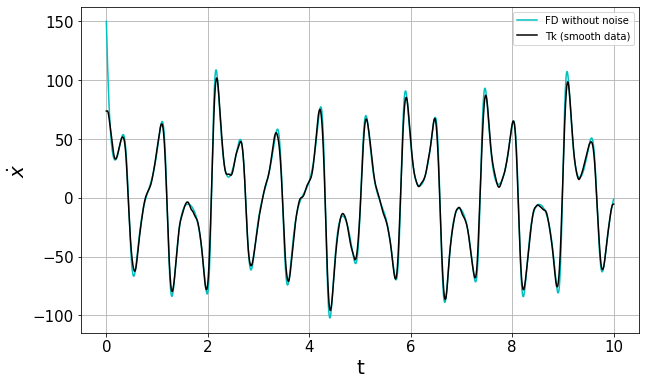

In [28]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, 'c-', label='FD without noise')
plt.plot(t[:10000], x_tik[0], color='black', label='Tk (smooth data)')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best')

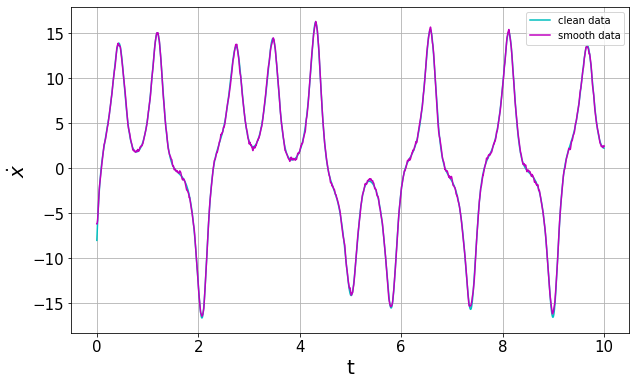

In [23]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x[:10000].real, 'c-', label='clean data')
plt.plot(t[:10000], xs, 'm-', label='smooth data')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best')

maxiter = 100

In [325]:
y_tik = simple_Tikhonov(x0, yn[:10000], dt, 100, 10**-6)

In [326]:
y_tik[1]

100

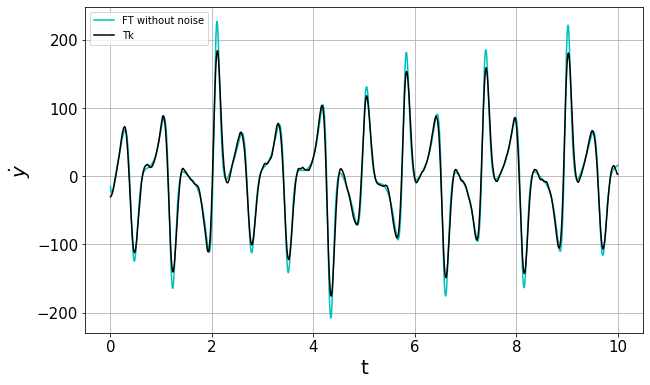

In [327]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y_t[:10000].real, 'c-', label='FD without noise')
plt.plot(t[:10000], y_tik[0], color='black', label='Tk')
#plt.plot(t[:10000], x_tik_m, 'r-', label='Tk_m')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot y$', fontsize=20)
plt.legend(loc='best')

In [340]:
w_y = SINdy(Theta_s, y_tik[0].reshape(subsample, 1), 0.24)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.367528 +0.000000i)
    + (23.927276 +0.000000i)x
    + (-0.898203 +0.000000i)xz
   


maxiter = 200

In [349]:
y_tik = simple_Tikhonov(x0, yn[:10000], dt, 200, 10**-6)

In [350]:
y_tik[1]

200

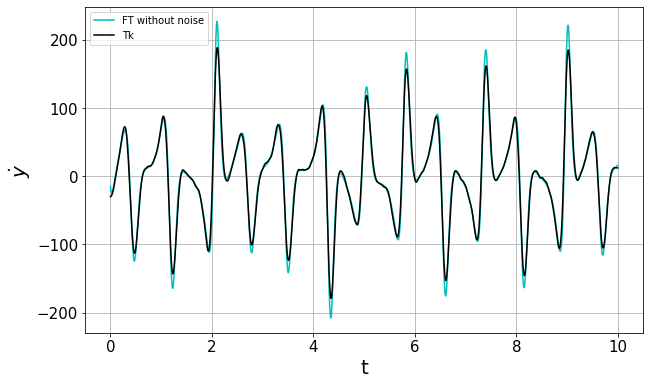

In [351]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y_t[:10000].real, 'c-', label='FD without noise')
plt.plot(t[:10000], y_tik[0], color='black', label='Tk')
#plt.plot(t[:10000], x_tik_m, 'r-', label='Tk_m')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot y$', fontsize=20)
plt.legend(loc='best')

In [380]:
w_y = SINdy(Theta_s, y_tik[0].reshape(subsample, 1), 0.1)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.332737 +0.000000i)
    + (-0.341233 +0.000000i)y
    + (24.942237 +0.000000i)x
    + (-0.920775 +0.000000i)xz
   


In [382]:
w_y = SINdy(Theta_s, y_tik[0].reshape(subsample, 1), 0.5)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (24.100752 +0.000000i)x
    + (-0.903876 +0.000000i)xz
   


In [29]:
y_tik = simple_Tikhonov(x0, ys, dt, 200, 10**-6)

In [34]:
y_tik[1]

200

In [32]:
w_y = SINdy(Theta_s, y_tik[0].reshape(subsample, 1), 0.5)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (23.596293 +0.000000i)x
    + (-0.885989 +0.000000i)xz
   


In [33]:
w_y = SINdy(Theta_s, y_tik[0].reshape(subsample, 1), 0.1)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.401880 +0.000000i)
    + (-0.151630 +0.000000i)y
    + (23.956484 +0.000000i)x
    + (-0.893246 +0.000000i)xz
   


## Data smoothing

In [15]:
def data_smoothing(x0, f, dx, iters, lam):
    n = len(f)
    e = np.ones(n-1)/dx
    D = diags([e, -e], [1, 0], shape=(n-1, n))
    L = lam*D.T.dot(D)
    ones = np.ones(n)
    E = diags(ones, 0, shape=(n, n))
    A =  csc_matrix(E + L)
    # Creation of the preconditioner
    inv_A = inv(A)
    sol = scipy.sparse.linalg.cg(A, f, x0, 1e-05, maxiter=iters, M=inv_A,atol=10**-6)
    return sol

In [16]:
def large_data_smoothing(f, dx, lam):
    n = len(f)
    diag = np.zeros(n)
    under_diag = np.zeros(n-1)
    x = np.zeros(n)
    y = np.zeros(n)
    D = np.zeros(2)
    D[0] = -lam/dx**2
    D[1] = 2*lam/dx**2
    diag[0] = np.sqrt(1-D[0])
    under_diag[0] = D[0]/diag[0]
    y[0] = f[0]/diag[0]
    for i in range(1, n-1):
        diag[i] = np.sqrt(1 + D[1] - under_diag[i-1]**2)
        under_diag[i] = D[0]/diag[i]
        y[i] = (f[i] - under_diag[i-1]*y[i-1])/diag[i]
    
    diag[n-1] = np.sqrt(1 - D[0] - under_diag[n-2]**2)
    y[n-1] = (f[n-1] - under_diag[n-2]*y[n-2])/diag[n-1]
    x[n-1] = y[n-1]/diag[n-1]
    for i in range(1, n):
        x[n-1-i] = (y[n-1-i] - under_diag[n-1-i]*x[n-i])/diag[n-1-i]
    return x   

Try to apply data smoothing

## Size = 20000

In [37]:
subsample = 20000
xs = data_smoothing(xn[:subsample], xn[:subsample], dt, 1, 10**-4)[0]
ys = data_smoothing(yn[:subsample], yn[:subsample], dt, 1, 10**-4)[0]
zs = data_smoothing(zn[:subsample], zn[:subsample], dt, 1, 10**-4)[0]

In [38]:
subsample = 20000
xs = xs.reshape(subsample, 1)
ys = ys.reshape(subsample, 1)
zs = zs.reshape(subsample, 1)
Xs_sub = np.hstack([xs,ys,zs])
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Theta_s, description = build_Theta(Xs_sub[:subsample,:], Xs_ders_sub, Xs_ders_descr, 5, data_description = ['x','y','z'])

In [39]:
x0 = np.random.uniform(-100, 100, subsample)
y_tik = Tikhonov_manually(x0, yn[:subsample], dt, 200, 10**-6)

The Initial residual
22602.221303987008
Start CG!
0.30921039578476917


In [40]:
y_tik.shape

(20000,)

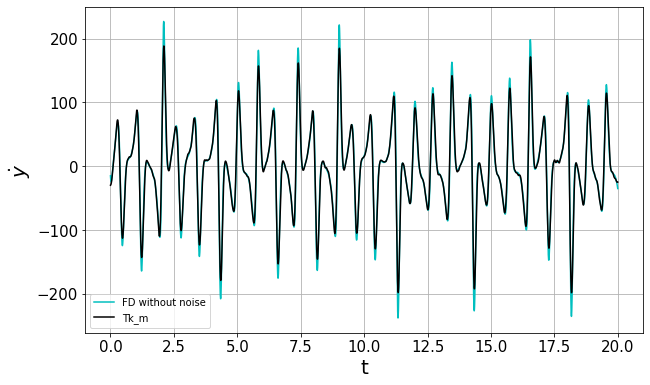

In [45]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:20000], y_t[:20000].real, 'c-', label='FD without noise')
plt.plot(t[:20000], y_tik, color='black', label='Tk_m')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot y$', fontsize=20)
plt.legend(loc='best')

In [44]:
w_y = SINdy(Theta_s, y_tik.reshape(subsample, 1), 0.2)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (-0.243018 +0.000000i)y
    + (24.680992 +0.000000i)x
    + (-0.915100 +0.000000i)xz
   


In [20]:
n = x.shape[0]
xn = np.zeros(n)
yn = np.zeros(n)
zn = np.zeros(n)
noise = 1
np.random.seed(0)
for i in range(n):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

In [25]:
x_0 = np.random.uniform(-100, 100, 1000)

In [26]:
xs = data_smoothing(x_0, xn[:1000], dt, 1, 10**-4)
ys = data_smoothing(x_0, yn[:1000], dt, 1, 10**-4)
zs = data_smoothing(x_0, zn[:1000], dt, 1, 10**-4)

In [27]:
print(xs[1], ys[1], zs[1])

0 0 0


In [29]:
xsub_t = FiniteDiff(xs[0], dt, 1).reshape(1000, 1)
ysub_t = FiniteDiff(ys[0], dt, 1).reshape(1000, 1)
zsub_t = FiniteDiff(zs[0], dt, 1).reshape(1000, 1)

In [30]:
subsample = 1000
xs = xs[0].reshape(subsample,1)
ys = ys[0].reshape(subsample,1)
zs = zs[0].reshape(subsample,1)
X_data_sub = np.hstack([xs,ys,zs])
X_ders_sub = np.ones((subsample,1))
X_ders_descr = ['']
Theta_s, description = build_Theta(X_data_sub, X_ders_sub, X_ders_descr, 5, data_description = ['x','y','z'])

In [31]:
wx_sub = SINdy(Theta_s, xsub_t, 2**-3)
print_pde(wx_sub, description, ut='dx/dt')
wy_sub = SINdy(Theta_s, ysub_t, 2**-3)
print_pde(wy_sub, description, ut='dy/dt')
wz_sub = SINdy(Theta_s, zsub_t, 2**-3)
print_pde(wz_sub, description, ut='dz/dt')

dx/dt = (-3410.063721 +0.000000i)
    + (341.445435 +0.000000i)z
    + (-1346.431396 +0.000000i)y
    + (2632.527588 +0.000000i)x
    + (-9.186371 +0.000000i)z^2
    + (233.466309 +0.000000i)yz
    + (20.106245 +0.000000i)y^2
    + (-331.626465 +0.000000i)xz
    + (-153.042099 +0.000000i)xy
    + (-2.905678 +0.000000i)x^2
    + (-12.934608 +0.000000i)yz^2
    + (-1.292205 +0.000000i)y^2z
    + (-0.455087 +0.000000i)y^3
    + (14.097971 +0.000000i)xz^2
    + (13.712727 +0.000000i)xyz
    + (-5.801836 +0.000000i)xy^2
    + (-2.137287 +0.000000i)x^2z
    + (20.392626 +0.000000i)x^2y
    + (-13.662941 +0.000000i)x^3
    + (0.243864 +0.000000i)yz^3
    + (-0.178266 +0.000000i)xz^3
    + (-0.454165 +0.000000i)xyz^2
    + (0.454227 +0.000000i)xy^2z
    + (-0.434021 +0.000000i)x^2yz
    + (-0.382855 +0.000000i)x^2y^2
    + (0.522557 +0.000000i)x^3z
   
dy/dt = (3202.057861 +0.000000i)
    + (-480.221008 +0.000000i)z
    + (-404.344360 +0.000000i)y
    + (576.857483 +0.000000i)x
    + (25.05522

### Using all data

In [17]:
xls = large_data_smoothing(xn, dt, 10**-4)
yls = large_data_smoothing(yn, dt, 10**-4)
zls = large_data_smoothing(zn, dt, 10**-4)

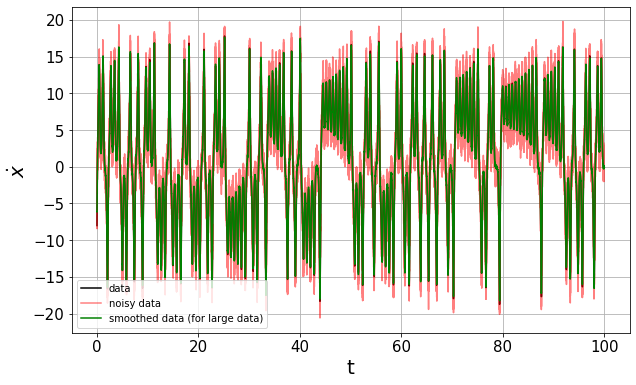

In [40]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t, x, 'black', label='data')
plt.plot(t, xn, 'r-', label='noisy data', alpha=0.5)
plt.plot(t, xls, 'g-', label='smoothed data (for large data)')

plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best',fontsize=10)

In [18]:
xs_t = FiniteDiff(xls, dt, 1).reshape(size,1)
ys_t = FiniteDiff(yls, dt, 1).reshape(size, 1)
zs_t = FiniteDiff(zls, dt, 1).reshape(size, 1)

In [19]:
xls = xls.reshape(size,1)
yls = yls.reshape(size,1)
zls = zls.reshape(size,1)
X_data = np.hstack([xls,yls,zls])
X_ders = np.ones((size,1))
X_ders_descr = ['']
Theta_ls, description = build_Theta(X_data, X_ders, X_ders_descr, 5, data_description = ['x','y','z'])

In [46]:
wx = SINdy(Theta_ls, xs_t, 2**-3)
print_pde(wx, description, ut='dx/dt')
wy = SINdy(Theta_ls, ys_t, 2**-3)
print_pde(wy, description, ut='dy/dt')
wz = SINdy(Theta_ls, zs_t, 2**-3)
print_pde(wz, description, ut='dz/dt')

dx/dt = (9.960095 +0.000000i)y
    + (-9.955483 +0.000000i)x
   
dy/dt = (-0.894468 +0.000000i)y
    + (27.601067 +0.000000i)x
    + (-0.991853 +0.000000i)xz
   
dz/dt = (-2.646333 +0.000000i)z
    + (0.998815 +0.000000i)xy
   


In [47]:
err = abs(np.array([(10 - 9.960095)*100/10, (10 - 9.955483)*100/10, (28-27.601067)*100/28, (1-0.894468)*100, (1-0.991853)*100,
                   (1 - 0.998815)*100, (8/3-2.646333)*100/8/3]))
print(np.mean(err))
print(np.std(err))

1.9771577607709745
3.5270035302710943


In [51]:
wy = SINdy(Theta_ls, ys_t, 0.09999)
print_pde(wy, description, ut='dy/dt')

dy/dt = (-0.894468 +0.000000i)y
    + (27.601067 +0.000000i)x
    + (-0.991853 +0.000000i)xz
   


In [30]:
xs_6 = data_smoothing(xn[:1000], xn[:1000], dt, 1, 10**-6)

In [249]:
xs_6[1]

0

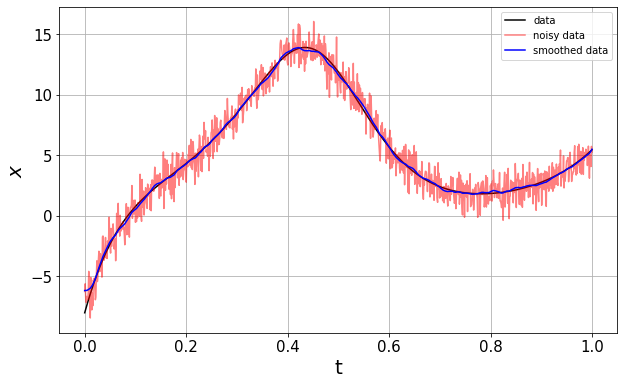

In [46]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:1000], x[:1000], 'black', label='data')
plt.plot(t[:1000], xn[:1000], 'r-', label='noisy data', alpha=0.5)
plt.plot(t[:1000], xls[:1000], 'b-', label='smoothed data')

plt.xlabel('t',fontsize=20)
plt.ylabel(r'$x$', fontsize=20)
plt.legend(loc='best',fontsize=10)
plt.savefig('smooth_x.pdf')

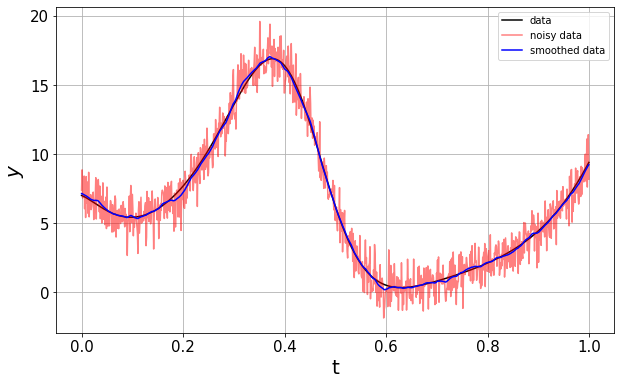

In [43]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:1000], y[:1000], 'black', label='data')
plt.plot(t[:1000], yn[:1000], 'r-', label='noisy data', alpha=0.5)
plt.plot(t[:1000], yls[:1000], 'b-', label='smoothed data')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.legend(loc='best',fontsize=10)
plt.savefig('smooth_y.pdf')

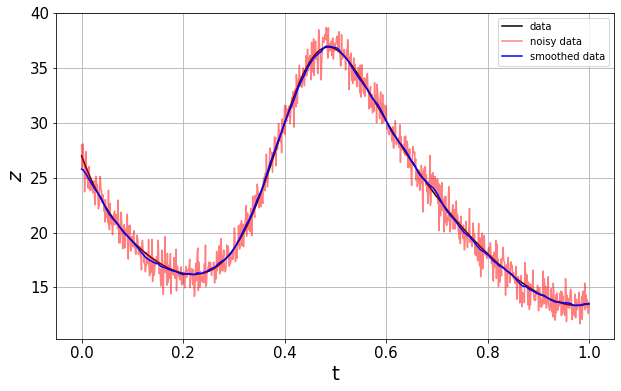

In [44]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:1000], z[:1000], 'black', label='data')
plt.plot(t[:1000], zn[:1000], 'r-', label='noisy data', alpha=0.5)
plt.plot(t[:1000], zls[:1000], 'b-', label='smoothed data')

plt.xlabel('t',fontsize=20)
plt.ylabel(r'$z$', fontsize=20)
plt.legend(loc='best',fontsize=10)
plt.savefig('smooth_z.pdf')

In [54]:
n = 1000
lam = 10**-3
e = np.ones(n-1)/dt
D = diags([e, -e], [1, 0], shape=(n-1, n))
L = lam*D.T.dot(D)
ones = np.ones(n)
E = diags(ones, 0, shape=(n, n))
A =  E + L

In [59]:
min(np.linalg.eig(A.todense())[0])

0.9999999999998949

In [60]:
max(np.linalg.eig(A.todense())[0])

4000.9901304037307

In [71]:
subsample = 1000
Xs_sub = np.hstack([xs,ys,zs])
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Theta_s, description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5, data_description = ['x','y','z'])

In [115]:
xs_tik = simple_Tikhonov(x0, xs, dt, 20, 10**-6)

Inverse matrix


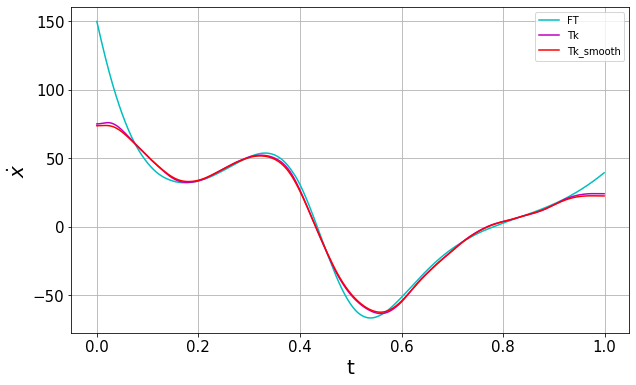

In [121]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:1000], x_t[:1000].real, 'c-', label='FT')
plt.plot(t[:1000], x_tik[0], 'm-', label='Tk')
plt.plot(t[:1000], xs_tik[0], 'r-', label='Tk_smooth')
plt.xlabel('t',fontsize=20)
plt.ylabel(r'$\dot x$', fontsize=20)
plt.legend(loc='best')

In [119]:
xs_tik[0].shape

(1000,)

## Identification of equation for smooth data

In [125]:
w_xs = SINdy(Theta_s, xs_tik[0].reshape(subsample,1), 1)
print_pde(w_xs, description, ut='dx/dt')

dx/dt = (-2.814462 +0.000000i)
    + (8.805805 +0.000000i)y
    + (-8.363387 +0.000000i)x
   


Increase data: use several times Tikonov differentiation

### 1) subsample = 1000 (10 times)

In [207]:
subsample = 1000
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Xt = np.zeros((subsample*10, 1))
Yt = np.zeros((subsample*10, 1))
Zt = np.zeros((subsample*10, 1))
Theta_s = np.zeros((subsample*10, 56))
for i in range(10):
    index = i*10000
    xs = data_smoothing(xn[index:index+subsample], xn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    ys = data_smoothing(yn[index:index+subsample], yn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    zs = data_smoothing(zn[index:index+subsample], zn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    print(f'Iteration {i}: Derivatives')
    x_0 = np.random.uniform(-100, 100, 1000)
    Xt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, xs, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Yt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, ys, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Zt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, zs, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Xs_sub = np.hstack([xs,ys,zs])
    Theta_s[i*subsample:(i+1)*subsample], description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5,\
                                                                    data_description = ['x','y','z'])

Iteration 0: Derivatives


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration 1: Derivatives
Iteration 2: Derivatives
Iteration 3: Derivatives
Iteration 4: Derivatives
Iteration 5: Derivatives
Iteration 6: Derivatives
Iteration 7: Derivatives
Iteration 8: Derivatives
Iteration 9: Derivatives


In [38]:
Theta_s.shape

(10000, 56)

In [40]:
Xt.shape

(10000, 1)

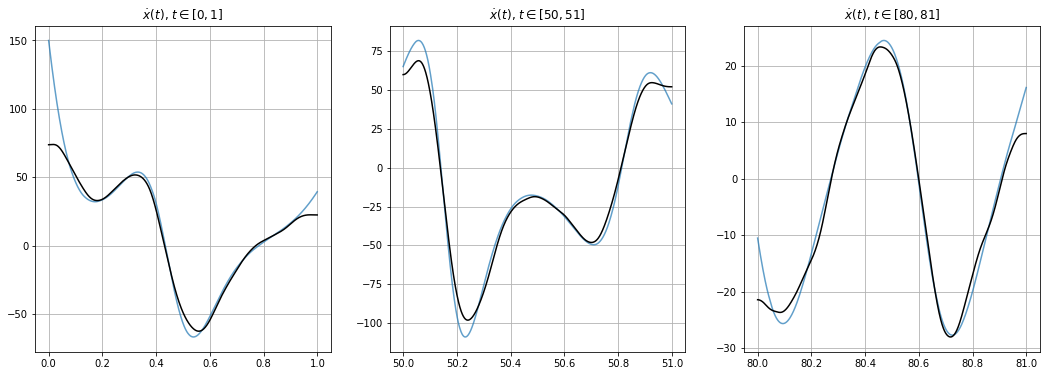

In [46]:
fig, axes = plt.subplots(1, 3)
for ax in fig.axes:
    ax.grid(True)


axes[0].plot(t[:1000], x_t[:1000].real, alpha=0.7)
axes[0].plot(t[:1000], Xt[:1000], color='black')
axes[0].set_title(r'$\dot x(t)$, $t\in [0, 1]$')



axes[1].plot(t[50000:51000], x_t[50000:51000].real, alpha=0.7)
axes[1].plot(t[50000:51000], Xt[5000:6000],color='black')
axes[1].set_title(r'$\dot x(t)$, $t\in [50, 51]$')



axes[2].plot(t[80000:81000], x_t[80000:81000].real, alpha=0.7)
axes[2].plot(t[80000:81000], Xt[8000:9000],color='black')
axes[2].set_title(r'$\dot x(t)$, $t \in [80, 81]$')

fig.set_figwidth(18)
fig.set_figheight(6) 
plt.show()

In [109]:
w_xs = SINdy(Theta_s, Xt, 0.4)
print_pde(w_xs, description, ut='dx/dt')

dx/dt = (9.374199 +0.000000i)y
    + (-9.428595 +0.000000i)x
   


In [69]:
w_ys = SINdy(Theta_s, Yt, 0.5)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (0.567496 +0.000000i)
    + (22.606439 +0.000000i)x
    + (-0.851973 +0.000000i)xz
   


In [100]:
w_ys = SINdy(Theta_s, Yt, 0.15)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (22.622400 +0.000000i)x
    + (-0.852114 +0.000000i)xz
   


Right terms are captured when $\xi \in [0.23, 0.46]$, but there is the wrong term...

In [133]:
w_zs = SINdy(Theta_s, Zt, 0.45)
print_pde(w_zs, description, ut='dz/dt')

dz/dt = (-0.875274 +0.000000i)
    + (-2.433843 +0.000000i)z
    + (0.928493 +0.000000i)xy
   


In [211]:
w_zs = SINdy(Theta_s, Zt, 0.48)
print_pde(w_zs, description, ut='dz/dt')

dz/dt = (-57.624869 +0.000000i)
    + (0.871649 +0.000000i)xy
   


### 2) subsample = 1000 (10 times)

In [135]:
subsample = 1000
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Xt = np.zeros((subsample*10, 1))
Yt = np.zeros((subsample*10, 1))
Zt = np.zeros((subsample*10, 1))
Theta_s = np.zeros((subsample*10, 56))
for i in range(10):
    index = i*1000
    xs = data_smoothing(xn[index:index+subsample], xn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    ys = data_smoothing(yn[index:index+subsample], yn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    zs = data_smoothing(zn[index:index+subsample], zn[index:index+subsample], dt, 3, 10**-4)[0].reshape(subsample, 1)
    print(f'Iteration {i}: Derivatives')
    x_0 = np.random.uniform(-100, 100, 1000)
    Xt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, xs, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Yt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, ys, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Zt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, zs, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Xs_sub = np.hstack([xs,ys,zs])
    Theta_s[i*subsample:(i+1)*subsample], description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5,\
                                                                    data_description = ['x','y','z'])

Iteration 0: Derivatives


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration 1: Derivatives
Iteration 2: Derivatives
Iteration 3: Derivatives
Iteration 4: Derivatives
Iteration 5: Derivatives
Iteration 6: Derivatives
Iteration 7: Derivatives
Iteration 8: Derivatives
Iteration 9: Derivatives


In [136]:
w_xs = SINdy(Theta_s, Xt, 0.4)
print_pde(w_xs, description, ut='dx/dt')

dx/dt = (9.491440 +0.000000i)y
    + (-9.484479 +0.000000i)x
   


In [206]:
w_ys = SINdy(Theta_s, Yt, 0.21)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (-0.775215 +0.000000i)
    + (0.213217 +0.000000i)y
    + (22.588070 +0.000000i)x
    + (-0.853807 +0.000000i)xz
   


In [162]:
w_ys = SINdy(Theta_s, Yt, 0.22)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (-0.796685 +0.000000i)
    + (23.126327 +0.000000i)x
    + (-0.864596 +0.000000i)xz
   


In [205]:
w_ys = SINdy(Theta_s, Yt, 0.8)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (23.083209 +0.000000i)x
    + (-0.863803 +0.000000i)xz
   


In [180]:
w_zs = SINdy(Theta_s, Zt, 0.9)
print_pde(w_zs, description, ut='dz/dt')

dz/dt = (-2.487874 +0.000000i)z
    + (0.929466 +0.000000i)xy
   


Variable 'y' causes more problems than others

In [216]:
subsample = 1000
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Yt = np.zeros((subsample*20, 1))
Theta_s = np.zeros((subsample*20, 56))
for i in range(20):
    index = i*1000
    xs = data_smoothing(xn[index:index+subsample], xn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    ys = data_smoothing(yn[index:index+subsample], yn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    zs = data_smoothing(zn[index:index+subsample], zn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    print(f'Iteration {i}: Derivatives')
    x_0 = np.random.uniform(-100, 100, 1000)
    Yt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, ys, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Xs_sub = np.hstack([xs,ys,zs])
    Theta_s[i*subsample:(i+1)*subsample], description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5,\
                                                                    data_description = ['x','y','z'])

Iteration 0: Derivatives


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


Iteration 1: Derivatives
Iteration 2: Derivatives
Iteration 3: Derivatives
Iteration 4: Derivatives
Iteration 5: Derivatives
Iteration 6: Derivatives
Iteration 7: Derivatives
Iteration 8: Derivatives
Iteration 9: Derivatives
Iteration 10: Derivatives
Iteration 11: Derivatives
Iteration 12: Derivatives
Iteration 13: Derivatives
Iteration 14: Derivatives
Iteration 15: Derivatives
Iteration 16: Derivatives
Iteration 17: Derivatives
Iteration 18: Derivatives
Iteration 19: Derivatives


In [225]:
w_ys = SINdy(Theta_s, Yt, 0.21)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (23.065740 +0.000000i)x
    + (-0.864795 +0.000000i)xz
   


In [228]:
w_ys = SINdy(Theta_s, Yt, 0.2)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (0.204265 +0.000000i)y
    + (22.553432 +0.000000i)x
    + (-0.854538 +0.000000i)xz
   


In [229]:
subsample = 1000
Xs_ders_sub = np.ones((subsample,1))
Xs_ders_descr = ['']
Yt = np.zeros((subsample*40, 1))
Theta_s = np.zeros((subsample*40, 56))
for i in range(40):
    index = i*1000
    xs = data_smoothing(xn[index:index+subsample], xn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    ys = data_smoothing(yn[index:index+subsample], yn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    zs = data_smoothing(zn[index:index+subsample], zn[index:index+subsample], dt, 1, 10**-4)[0].reshape(subsample, 1)
    print(f'Iteration {i}: Derivatives')
    x_0 = np.random.uniform(-100, 100, 1000)
    Yt[i*subsample:(i+1)*subsample, :] = simple_Tikhonov(x0, ys, dt, 1, 10**-6)[0].reshape(subsample, 1)
    Xs_sub = np.hstack([xs,ys,zs])
    Theta_s[i*subsample:(i+1)*subsample], description = build_Theta(Xs_sub, Xs_ders_sub, Xs_ders_descr, 5,\
                                                                    data_description = ['x','y','z'])

Iteration 0: Derivatives


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


Iteration 1: Derivatives
Iteration 2: Derivatives
Iteration 3: Derivatives
Iteration 4: Derivatives
Iteration 5: Derivatives
Iteration 6: Derivatives
Iteration 7: Derivatives
Iteration 8: Derivatives
Iteration 9: Derivatives
Iteration 10: Derivatives
Iteration 11: Derivatives
Iteration 12: Derivatives
Iteration 13: Derivatives
Iteration 14: Derivatives
Iteration 15: Derivatives
Iteration 16: Derivatives
Iteration 17: Derivatives
Iteration 18: Derivatives
Iteration 19: Derivatives
Iteration 20: Derivatives
Iteration 21: Derivatives
Iteration 22: Derivatives
Iteration 23: Derivatives
Iteration 24: Derivatives
Iteration 25: Derivatives
Iteration 26: Derivatives
Iteration 27: Derivatives
Iteration 28: Derivatives
Iteration 29: Derivatives
Iteration 30: Derivatives
Iteration 31: Derivatives
Iteration 32: Derivatives
Iteration 33: Derivatives
Iteration 34: Derivatives
Iteration 35: Derivatives
Iteration 36: Derivatives
Iteration 37: Derivatives
Iteration 38: Derivatives
Iteration 39: Derivat

The error in definition of coefficients is saved 

In [240]:
w_ys = SINdy(Theta_s, Yt, 0.17)
print_pde(w_ys, description, ut='dy/dt')

dy/dt = (0.170668 +0.000000i)y
    + (22.673779 +0.000000i)x
    + (-0.858953 +0.000000i)xz
   


# Barycentric derivative

In [56]:
Cheb_data = sio.loadmat('C:/Users/Margarita/Desktop/PDE-FIND-master/Datasets/Lorenz_system_Chebyshev.mat')

In [57]:
t_c = Cheb_data['t_c'].T[0]
x_c = Cheb_data['x_c'].T[0]
y_c = Cheb_data['y_c'].T[0]
z_c = Cheb_data['z_c'].T[0]

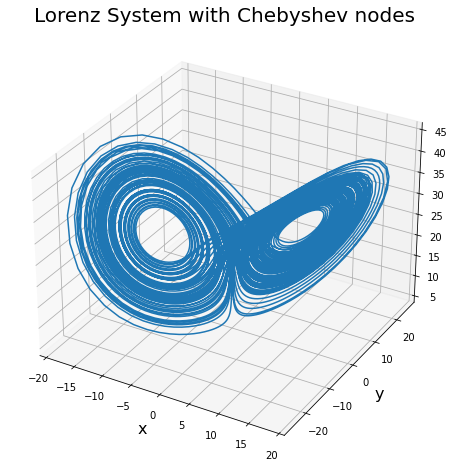

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_c, y_c, z_c, label='parametric curve')
plt.title('Lorenz System with Chebyshev nodes', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
fig.set_figwidth(12)
fig.set_figheight(8) 

In [58]:
dt_c = t[2]-t[1]
size = t.shape[0]

In [119]:
t_c[2] - t_c[1]

7.40220300343708e-06

In [121]:
t_c[110] - t_c[100]

0.00518060053794045

In [59]:
np.random.seed(0)
length = t_c.shape[0]
xc_n = np.zeros(length)
yc_n = np.zeros(length)
zc_n = np.zeros(length)
part = 50;

noise = 1
for i in range(length):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()

In [90]:
xc_ls = large_data_smoothing(xc_n, dt, 10**-4)
yc_ls = large_data_smoothing(yc_n, dt, 10**-4)
zc_ls = large_data_smoothing(zc_n, dt, 10**-4)

In [87]:
l = np.zeros(length); 
d_x = np.zeros(length); 
d_y = np.zeros(length);
d_z = np.zeros(length);

In [88]:
d_x.shape

(10001,)

In [91]:
n = length;
c = np.flip(np.ones(n)*(-1)**np.arange(0,n));
c[0] = 0.5*(-1)**n
c[n-1] = 0.5

for i in range(length): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(t_c[i] - t_c[:i])
    l[i+1:] = c[i+1:]/c[i]/(t_c[i] - t_c[i+1:])
    l[i] = - sum(l)
    d_x[i] = xc_ls.dot(l) 
    d_y[i] = yc_ls.dot(l)
    d_z[i] = zc_ls.dot(l)

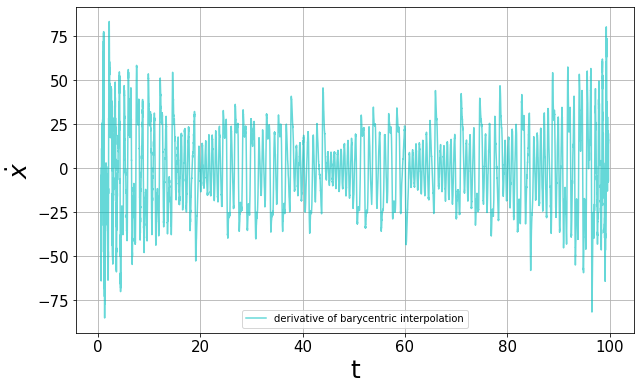

In [81]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.plot(t[100:20000], x_t[100:20000], 'black', label='FD')
plt.plot(t_c[500:-300], d_x[500:-300],'c-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


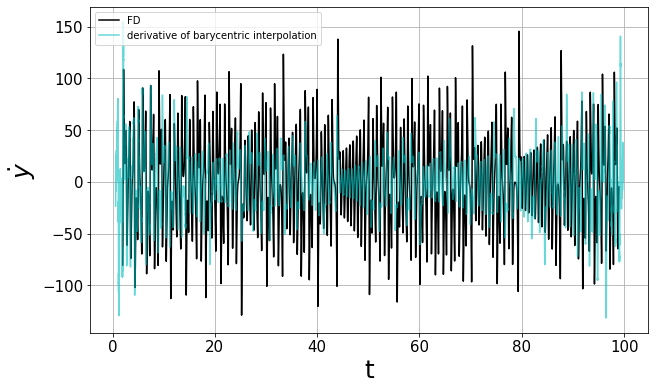

In [95]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[2000:-1000], x_t[2000:-1000], 'black', label='FD')
plt.plot(t_c[500:-300], d_y[500:-300],'c-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot y$', fontsize=25)
plt.legend(loc='best')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


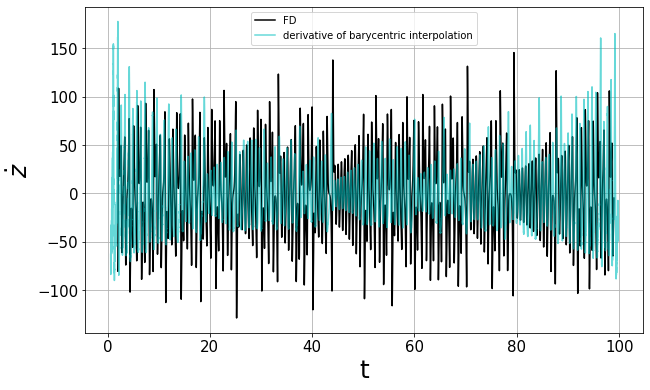

In [106]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[2000:-1000], x_t[2000:-1000], 'black', label='FD')
plt.plot(t_c[500:-300], d_z[500:-300],'c-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot z$', fontsize=25)
plt.legend(loc='best')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


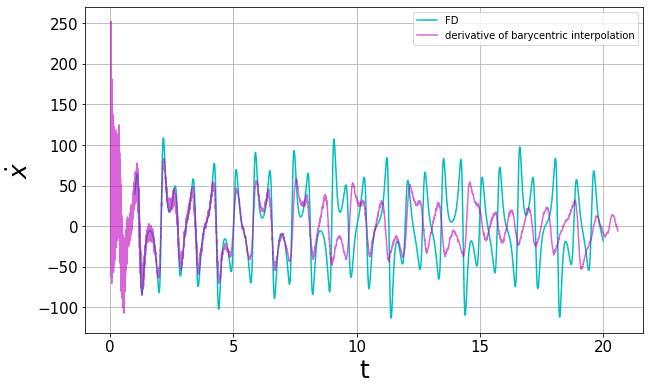

In [47]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[1000:20000], x_t[1000:20000], 'c-', label='FD')
plt.plot(t_c[100:3000], d_x[100:3000],'m-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

In [72]:
xc_ls_r = xc_ls.reshape(length,1)
yc_ls_r = yc_ls.reshape(length,1)
zc_ls_r = zc_ls.reshape(length,1)
X_data = np.hstack([xc_ls_r, yc_ls_r, zc_ls_r])
X_ders = np.ones((length,1))
X_ders_descr = ['']
Thetaс_ls, description = build_Theta(X_data, X_ders, X_ders_descr, 5, data_description = ['x','y','z'])
#['1'] + description[1:]

In [70]:
xc_ls

array([[-7.37391674],
       [-7.38529643],
       [-7.41294172],
       ...,
       [10.64925239],
       [10.63390919],
       [10.63564242]])

In [96]:
d_x_r = d_x.reshape(length,1)
d_y_r = d_y.reshape(length,1)
d_z_r = d_z.reshape(length,1)

In [98]:
wx = SINdy(Thetaс_ls[500:-300, :], d_x_r[500:-300], 2**-3)
print_pde(wx, description, ut='dx/dt')

dx/dt = (9.932000 +0.000000i)y
    + (-9.932149 +0.000000i)x
   


In [113]:
wy = SINdy(Thetaс_ls[500:-300, :], d_y_r[500:-300], 0.5)
print_pde(wy, description, ut='dy/dt')

dy/dt = (3.458458 +0.000000i)y
    + (13.708507 +0.000000i)x
    + (-0.705171 +0.000000i)xz
   


In [114]:
wz = SINdy(Thetaс_ls[500:-300, :], d_z_r[500:-300], 0.5)
print_pde(wz, description, ut='dz/dt')

dz/dt = (6.165339 +0.000000i)
    + (-2.196636 +0.000000i)z
    + (0.976432 +0.000000i)xy
   


FD is much better.

# Try to take Tikhonov derivatives with size=10000.

In [127]:
np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

In [128]:
xls = large_data_smoothing(xn, dt, 10**-4)
yls = large_data_smoothing(yn, dt, 10**-4)
zls = large_data_smoothing(zn, dt, 10**-4)

In [136]:
xls_r = xls.reshape(size,1)
yls_r = yls.reshape(size,1)
zls_r = zls.reshape(size,1)
Xn_data = np.hstack([xls_r,yls_r,zls_r])
X_ders = np.ones((size,1))
X_ders_descr = ['']
Theta_s, _ = build_Theta(Xn_data, X_ders, X_ders_descr, 5, data_description = ['x','y','z'])

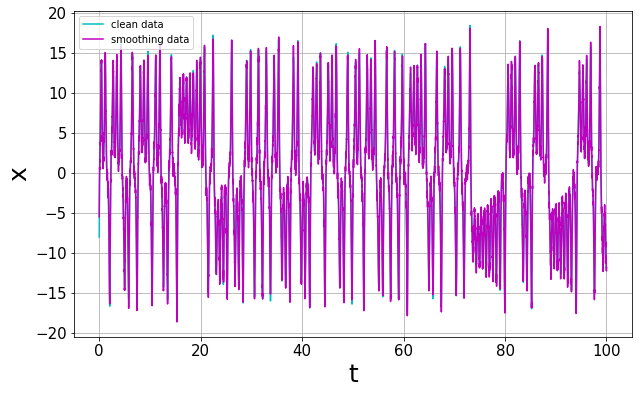

In [130]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t, x, 'c-', label='clean data')
plt.plot(t, xls,'m-', label='smoothing data')
plt.xlabel('t', fontsize=25)
plt.ylabel('x', fontsize=25)
plt.legend(loc='best')

In [131]:
x0 = np.random.uniform(-100, 100, size)

In [137]:
y_tik = Tikhonov_manually(x0, yls, dt, 200, 10**-6)

The Initial residual
199925.4544388586
Start CG!
7.635232641553174


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


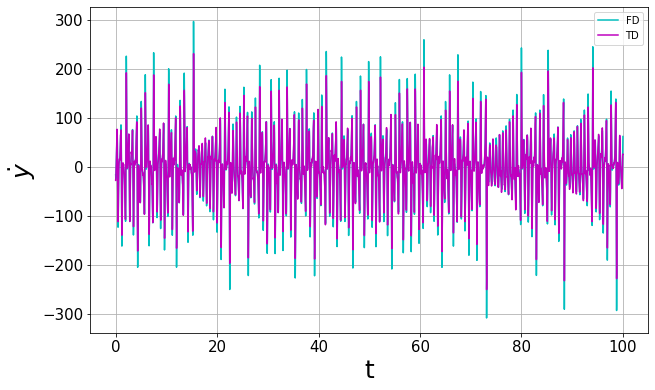

In [139]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t, y_t, 'c-', label='FD')
plt.plot(t, y_tik,'m-', label='TD')
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot y$', fontsize=25)
plt.legend(loc='best')

In [140]:
w_y = SINdy(Theta_s, y_tik.reshape(size, 1), 0.24)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.303800 +0.000000i)y
    + (22.424445 +0.000000i)x
    + (-0.856426 +0.000000i)xz
   


In [144]:
w_y = SINdy(Theta_s, y_tik.reshape(size, 1), 0.2)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.303800 +0.000000i)y
    + (22.424445 +0.000000i)x
    + (-0.856426 +0.000000i)xz
   
